Imported successfully
Loaded dataset successfully


Extraction des labels: 100%|██████████| 4/4 [00:00<?, ?it/s]


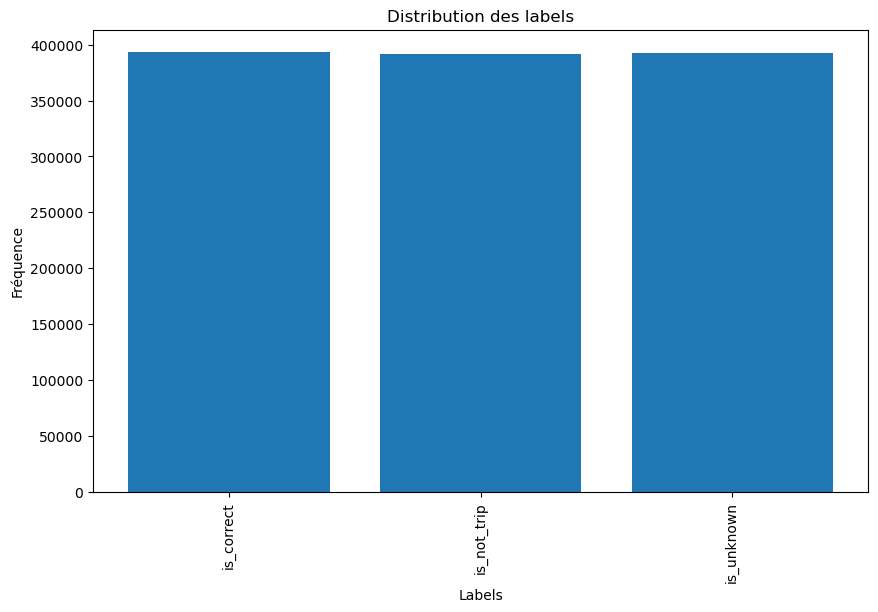

Séparation des données: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Entraînement du modèle KNN...


Entraînement du modèle KNN: 100%|██████████| 3/3 [00:36<00:00, 12.09s/it]



Entraînement terminé...

Rapport de classification :


C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  is_correct       1.00      0.99      1.00     19596
 is_not_trip       0.98      0.96      0.97     19645
  is_unknown       0.96      0.99      0.97     19663

   micro avg       0.98      0.98      0.98     58904
   macro avg       0.98      0.98      0.98     58904
weighted avg       0.98      0.98      0.98     58904
 samples avg       0.89      0.89      0.89     58904



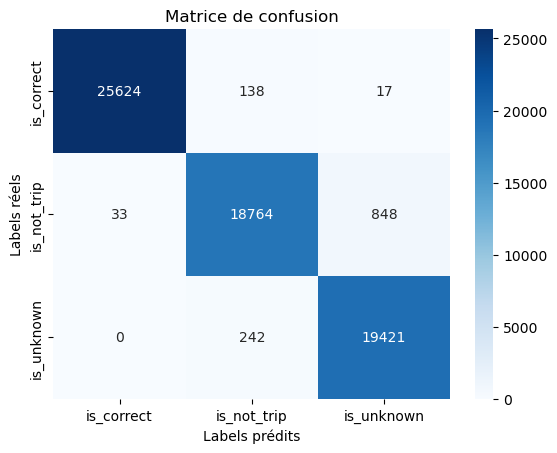

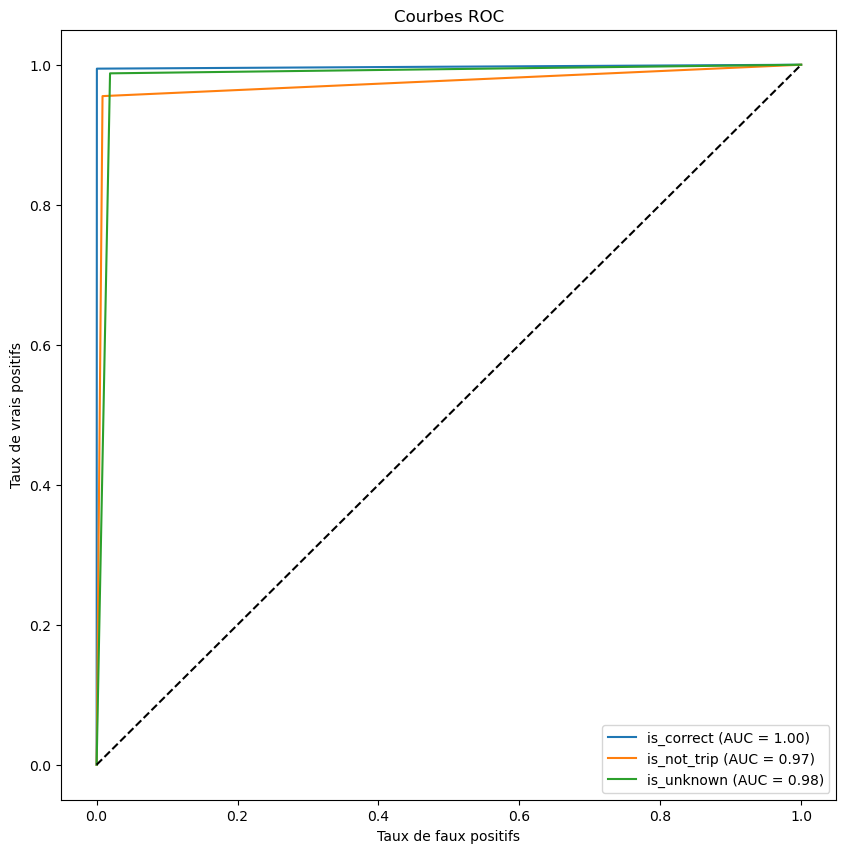


Prédictions sur de nouveaux textes :
* Je vais à la boulangerie acheter du pain
 - is_correct => 0.0%
 - is_not_trip => 100.0%
 - is_unknown => 0.0%

* I need to go from London to Paris
 - is_correct => 0.0%
 - is_not_trip => 60.0%
 - is_unknown => 0.0%

* Je voudrais partir de Paris et aller à Nice
 - is_correct => 20.0%
 - is_not_trip => 80.0%
 - is_unknown => 0.0%

* Find me a route from Berlin to Munich
 - is_correct => 0.0%
 - is_not_trip => 80.0%
 - is_unknown => 20.0%

* Je souhaite aller à l'aéroport de Roissy
 - is_correct => 0.0%
 - is_not_trip => 100.0%
 - is_unknown => 0.0%

* How do I get from the station to the airport?
 - is_correct => 0.0%
 - is_not_trip => 100.0%
 - is_unknown => 0.0%

* Peux-tu m'indiquer le chemin du musée au parc?
 - is_correct => 0.0%
 - is_not_trip => 80.0%
 - is_unknown => 20.0%

* Take me from Times Square to Central Park
 - is_correct => 0.0%
 - is_not_trip => 60.0%
 - is_unknown => 40.0%

* Je suis à Bordeaux, je veux aller à Lyon
 - is_corre

In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("Imported successfully")

# Fonction de chargement du dataset
def load_dataset(dataset_path):
    dataset = pd.read_csv(dataset_path, sep=";")
    return dataset

# Appel de la fonction
dataset_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/text/text_intention_detector.csv"
dataset = load_dataset(dataset_path)

print("Loaded dataset successfully")

# Fonction pour obtenir les mappings de labels avec tqdm
def get_label_mappings(dataset):
    labels = [label for label in tqdm(dataset.columns, desc="Extraction des labels") if label != 'sentence']
    id2label = {i: label for i, label in enumerate(labels)}
    label2id = {v: k for k, v in id2label.items()}
    return labels, id2label, label2id

# Appel de la fonction
labels, id2label, label2id = get_label_mappings(dataset)

# Fonction de visualisation de la distribution des labels
def plot_label_distribution(labels, dataset):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, [sum(dataset[label]) for label in labels])
    plt.title("Distribution des labels")
    plt.xlabel("Labels")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=90)
    plt.show()

# Appel de la fonction
plot_label_distribution(labels, dataset)

# Fonction de séparation des données en train, validation et test avec tqdm
def split_data(dataset, labels, frac=0.5, test_size=0.2, random_state=42):
    tqdm_desc = "Séparation des données"
    with tqdm(total=4, desc=tqdm_desc) as pbar:
        X = dataset['sentence']
        y = dataset[labels]
        pbar.update(1)  # Étape 1 : Extraction des colonnes

        X = X.sample(frac=frac, random_state=random_state)
        y = y.loc[X.index]
        pbar.update(1)  # Étape 2 : Échantillonnage aléatoire

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
        pbar.update(1)  # Étape 3 : Première séparation train / temp

        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
        pbar.update(1)  # Étape 4 : Deuxième séparation temp / validation et test
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Appel de la fonction
X_train, X_val, X_test, y_train, y_val, y_test = split_data(dataset, labels)

# Fonction pour créer et entraîner le modèle avec tqdm
def train_model_knn(X_train, y_train, n_neighbors=5):
    steps = ['Initialisation du pipeline', 'Vectorisation des données', 'Entraînement du modèle']
    pipeline = None

    with tqdm(total=len(steps), desc="Entraînement du modèle KNN") as pbar:
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer(min_df=100)),
            ('classifier', OneVsRestClassifier(
                KNeighborsClassifier(
                    n_neighbors=n_neighbors,
                    n_jobs=-1
                )
            ))
        ])
        pbar.update(1)  # Étape 1

        pipeline.named_steps['vectorizer'].fit(X_train)
        pbar.update(1)  # Étape 2

        pipeline.fit(X_train, y_train)
        pbar.update(1)  # Étape 3

    return pipeline

# Appel de la fonction
print("Entraînement du modèle KNN...")
pipeline_knn = train_model_knn(X_train, y_train)
print("\nEntraînement terminé...")

# Fonction pour évaluer le modèle
def evaluate_model(pipeline, X_test, y_test, labels):
    y_pred = pipeline.predict(X_test)

    # Rapport de classification
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Matrice de confusion
    cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.title('Matrice de confusion')
    plt.xlabel('Labels prédits')
    plt.ylabel('Labels réels')
    plt.show()

    # Courbes ROC
    plot_roc_curve(y_test, y_pred, labels)

# Fonction pour tracer les courbes ROC
def plot_roc_curve(y_test, y_pred, labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 10))
    for i in range(len(labels)):
        plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC')
    plt.legend()
    plt.show()

# Appel de la fonction
evaluate_model(pipeline_knn, X_test, y_test, labels)

# Fonction pour prédire sur de nouveaux exemples
def predict_new_texts(pipeline, texts, id2label):
    predicted_labels = pipeline.predict(texts)
    predicted_proba = pipeline.predict_proba(texts)

    print("\nPrédictions sur de nouveaux textes :")
    for text, p_labels, prob in zip(texts, predicted_labels, predicted_proba):
        print(f"* {text}")
        for i, score in enumerate(prob):
            print(f" - {id2label[i]} => {round(score * 100, 1)}%")
        print()

# Appel de la fonction pour prédire
texts = [
    "Je vais à la boulangerie acheter du pain",
    "I need to go from London to Paris",
    "Je voudrais partir de Paris et aller à Nice",
    "Find me a route from Berlin to Munich",
    "Je souhaite aller à l'aéroport de Roissy",
    "How do I get from the station to the airport?",
    "Peux-tu m'indiquer le chemin du musée au parc?",
    "Take me from Times Square to Central Park",
    "Je suis à Bordeaux, je veux aller à Lyon",
    "Je veux partir de la Gare Saint-Lazare vers Montparnasse",
    "I want to travel from New York to Los Angeles",
    "Comment aller de la plage à la gare ?",
    "I would like to travel from the hotel to the conference center",
    "Aidez-moi à trouver un trajet de Paris à Barcelone",
    "Donne-moi un itinéraire de la Tour Eiffel à Notre-Dame",
    "Trouve un itinéraire pour aller de Marseille à Toulon",
    "J'aimerais partir de la gare de Lyon vers la gare de Montparnasse",
    "I'm looking for directions from the airport to the city center",
    "J'ai besoin d'un itinéraire entre le centre-ville et le musée d'Orsay",
    "Voyagez de Paris à Sannois",
    "frfreferuzbrore0998329839729####"
]
predict_new_texts(pipeline_knn, texts, id2label)
